# Skip-gram Word2Vec

## Some Theory 

### Word embedding

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an embedding lookup and the number of hidden units is the embedding dimension.

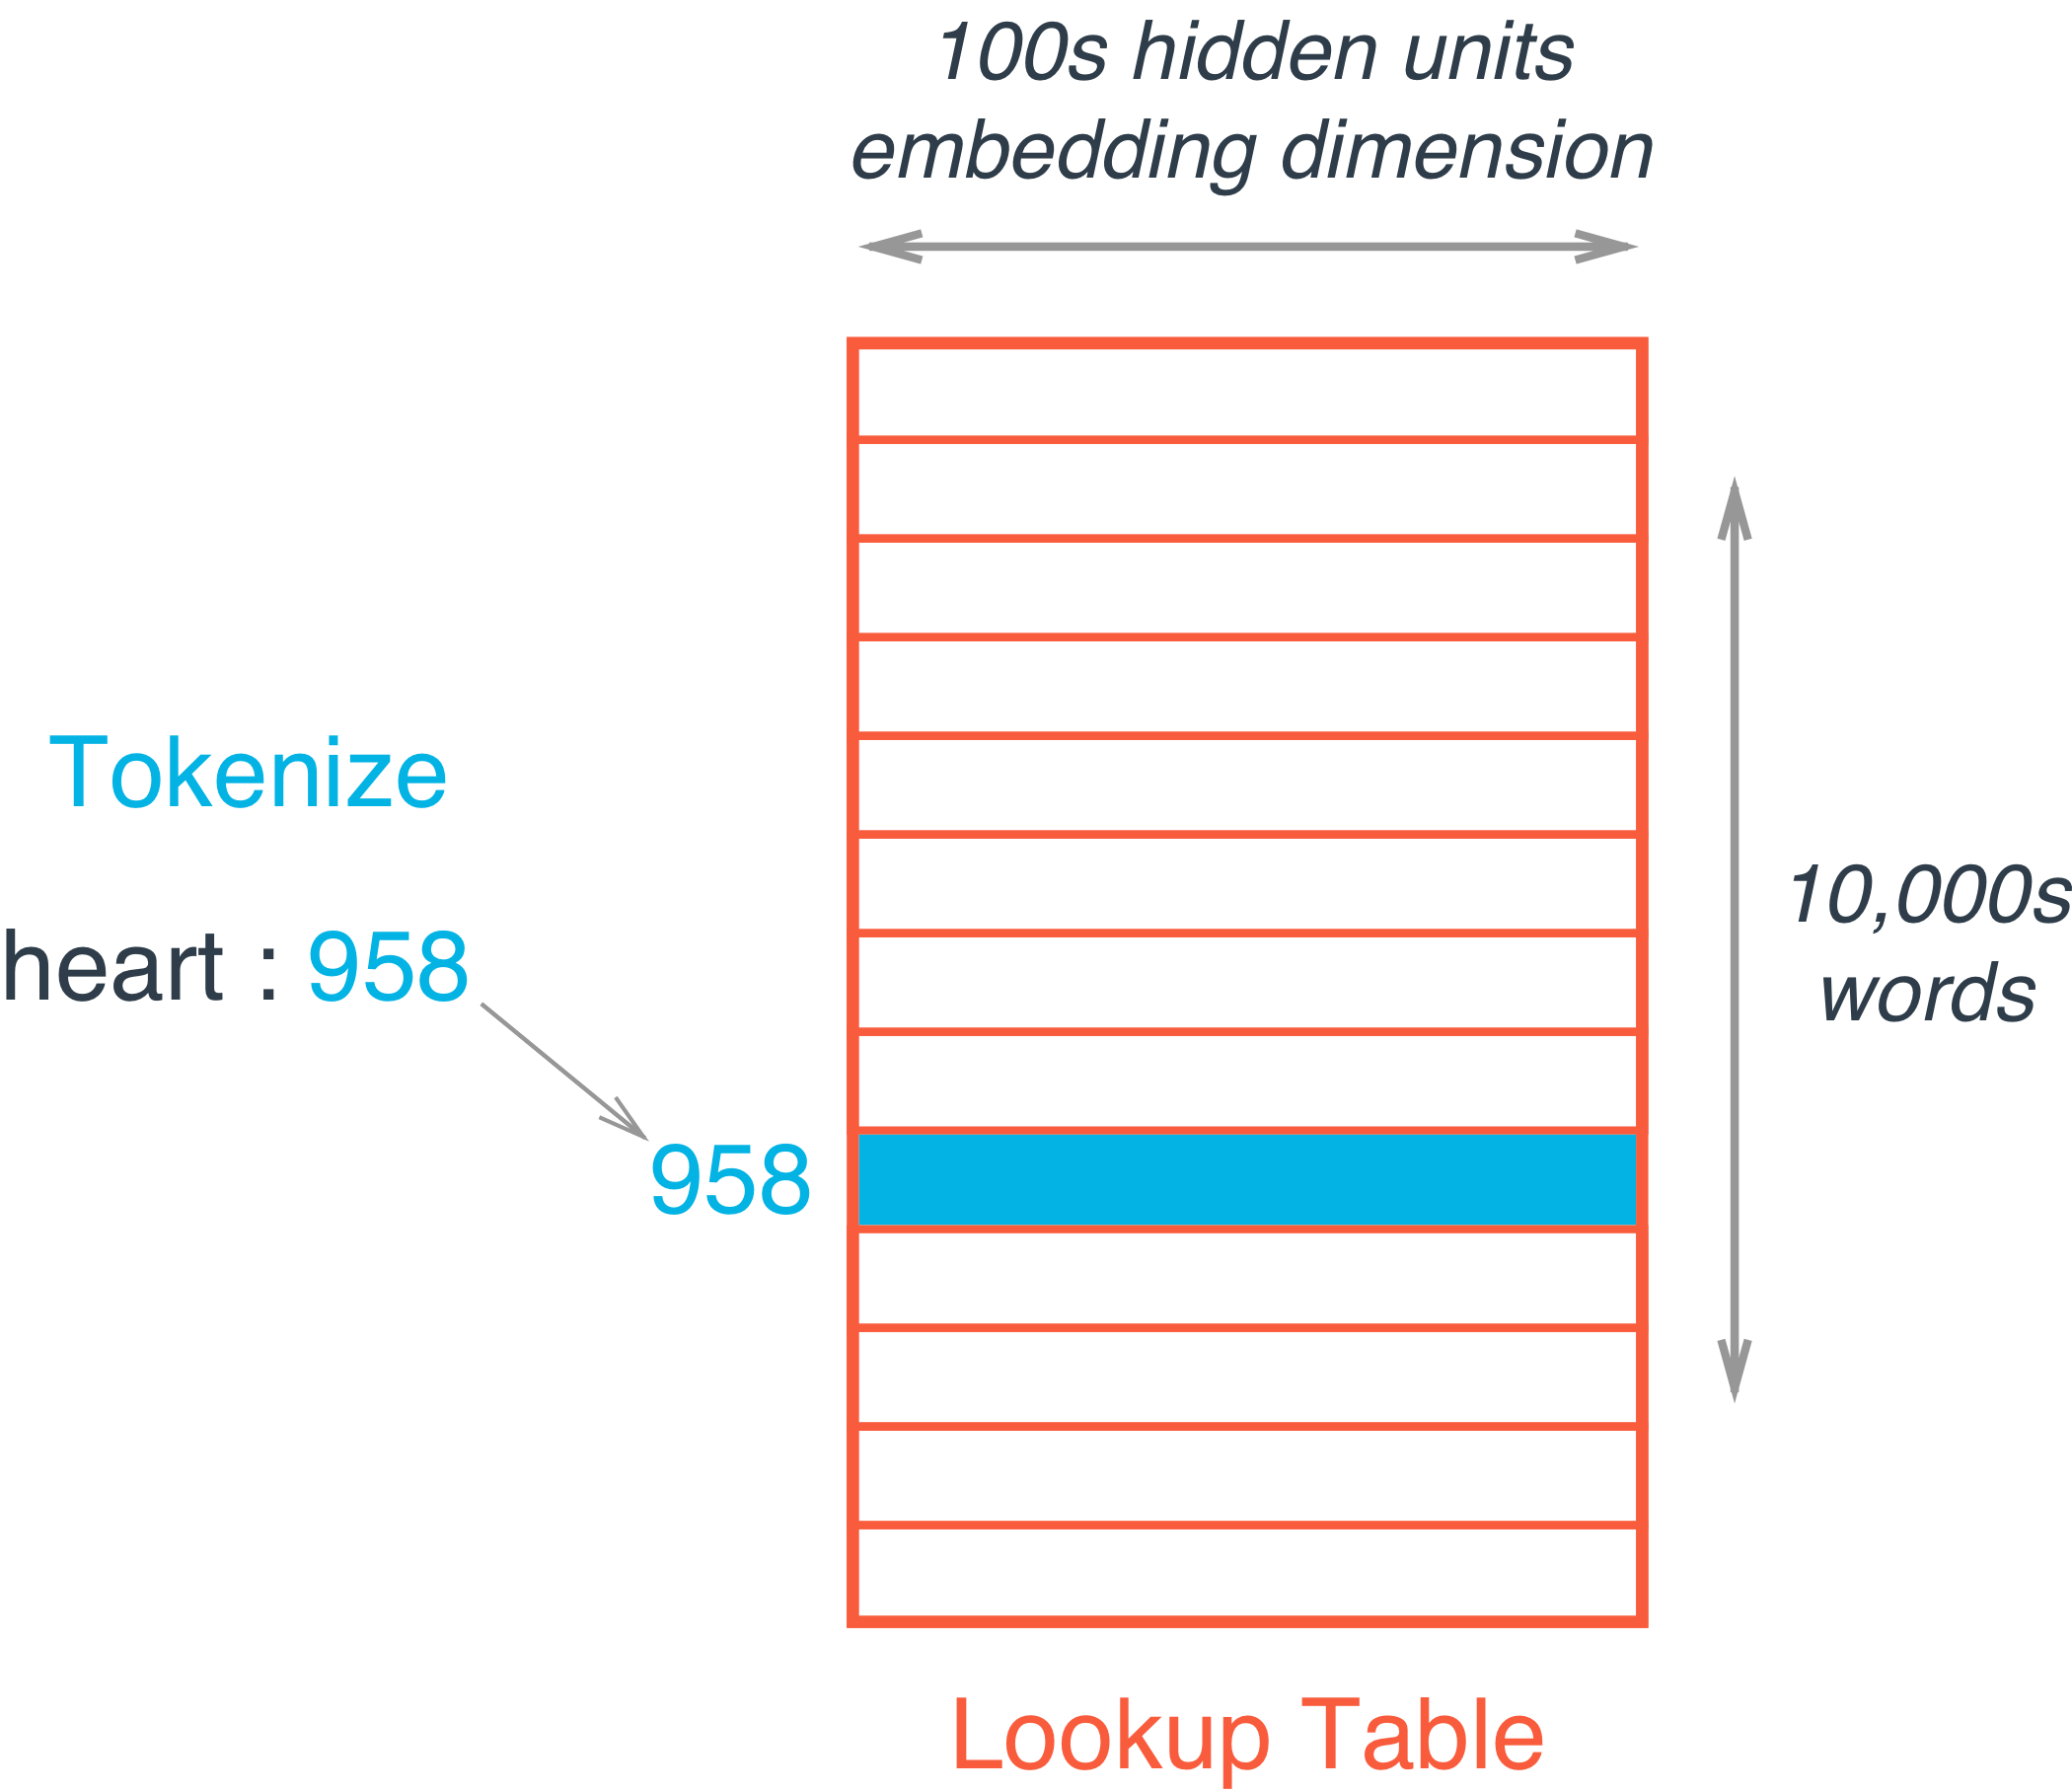

In [1]:
from IPython.display import Image

Image(filename='assets/tokenize_lookup.png', width='50%')

### Word2Vec: Skip Gram model

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

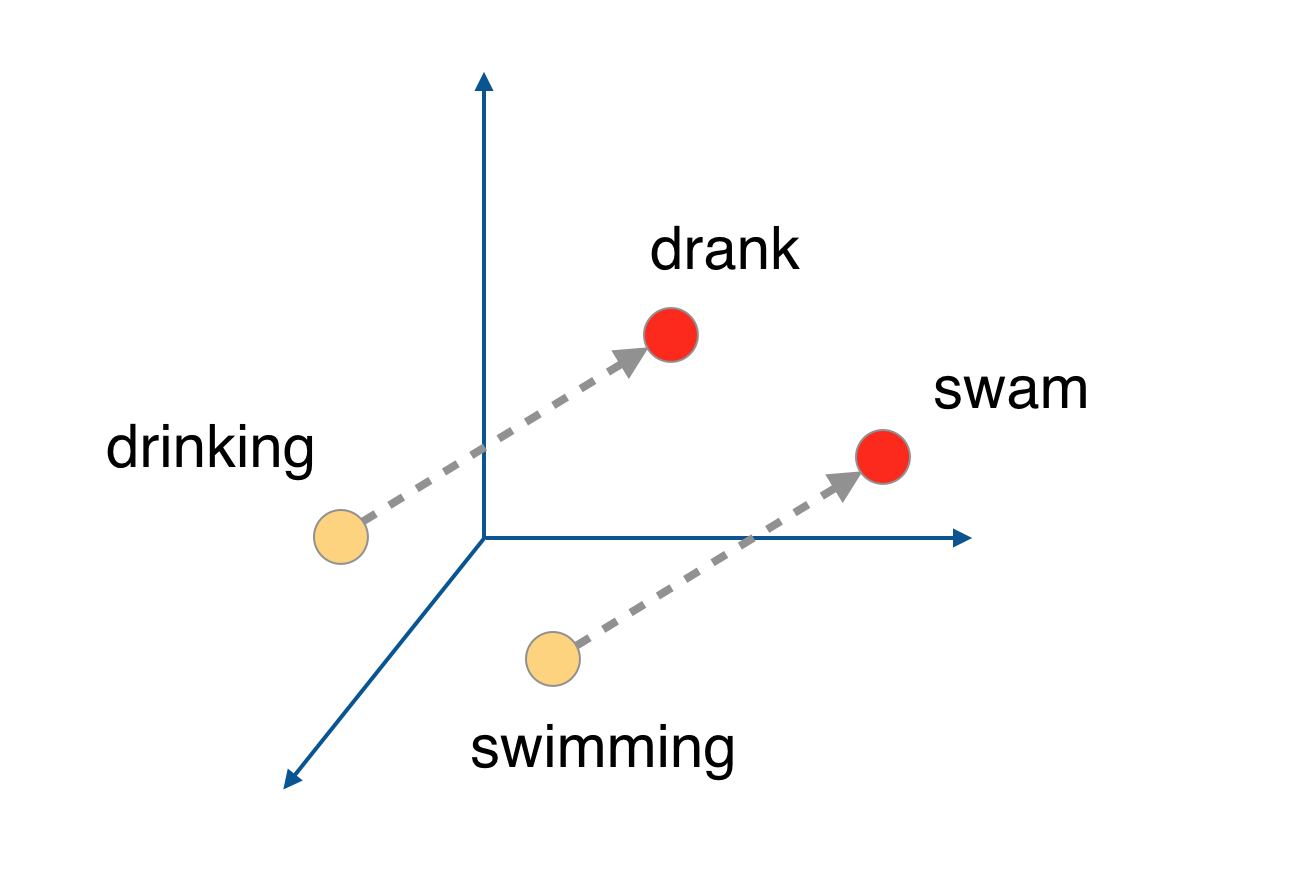

In [2]:
Image(filename='assets/vector_distance.png', width='40%')

SkipGram: we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts

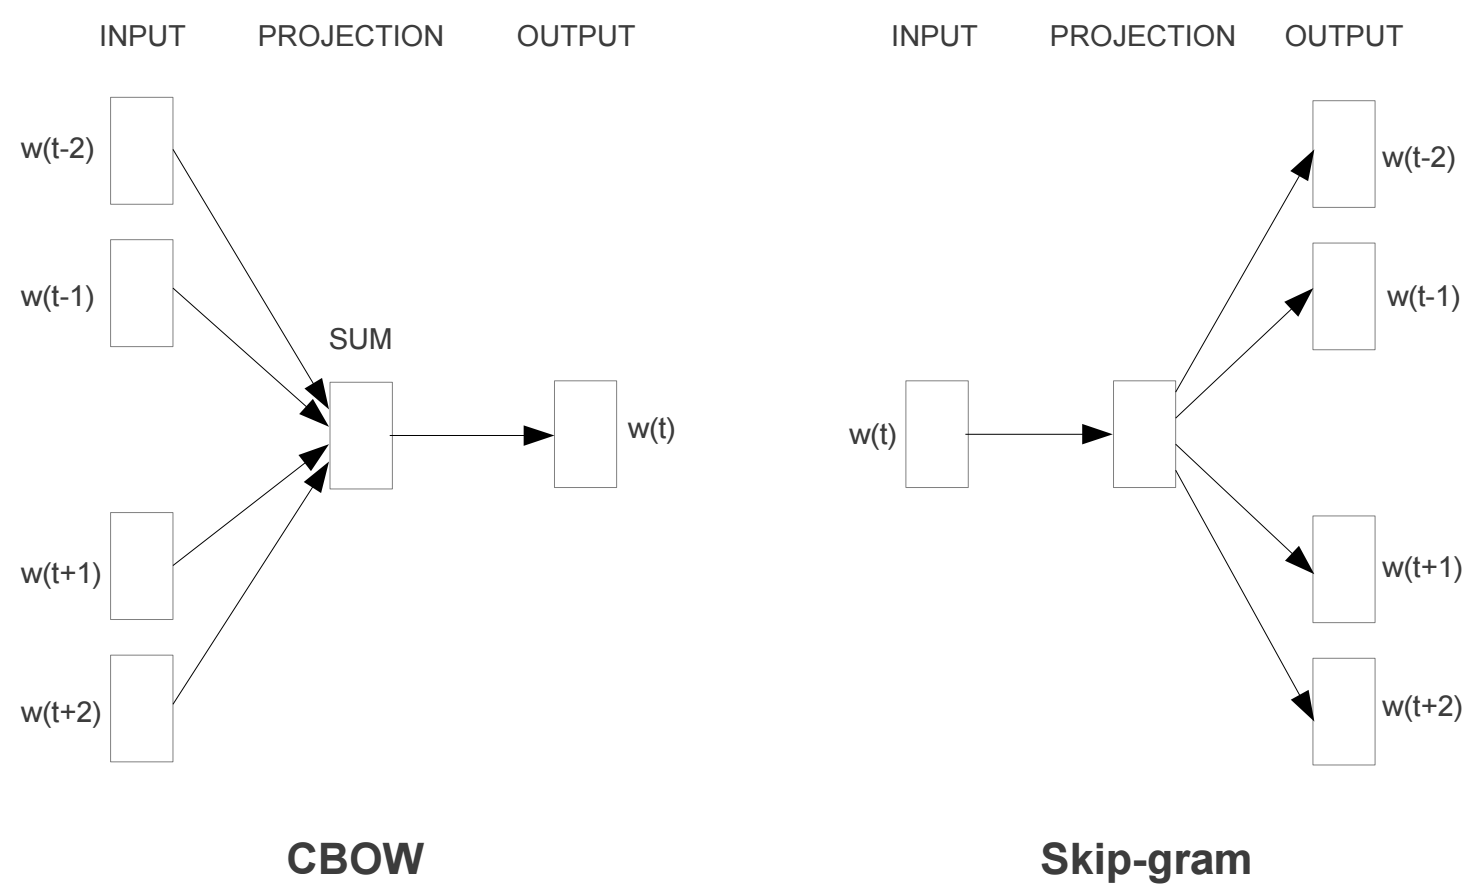

In [3]:
Image(filename="assets/word2vec_architectures.png", width='60%')

## Data

In [4]:
with open('data/text8') as f:
    text = f.read()
    
text[:100]

' anarchism originated as a term of abuse first used against early working class radicals including t'

## Pre-processing

Use two function from `utils.py`: pre processing and create_lookup_tables

In [5]:
import utils

words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [6]:
# some stats about the text
print('Total words:',len(words))
print('Uniques words:',len(set(words)))

Total words: 16680599
Uniques words: 63641


In [7]:
vocab2int, int2vocab = utils.create_lookup_tables(words)
int_words = [vocab2int[word] for word in words]
print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsamplig

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$

In [8]:
from collections import Counter
import numpy as np
import random

threshold = 1e-5
total_words = len(int_words)
word_counts = Counter(int_words)

prob = {int_word: 1-(threshold/(count/total_words))**0.5 for int_word, count in word_counts.items()}
train_words = [word for word in int_words if 1 - prob[word] > random.random()]

In [9]:
print('Total words in train_words:', len(train_words))
print('Uniques words in train_words:', len(set(train_words)))

Total words in train_words: 4627256
Uniques words in train_words: 63641


Reduce total words from 16,680,599 to 4,629,218.

## Batches

From Mikolov et al.:

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose  𝐶=5 , for each training word we will select randomly a number  𝑅  in range  [1:𝐶] , and then use  𝑅  words from history and  𝑅  words from the future of the current word as correct labels."

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [10]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size + 1)
    
    return [words[i] for i in range(len(words)) if not (i > idx + R or i < idx - R or i == idx)]

In [11]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [12]:
# test the code
lista = [5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
idx = 5

get_target(lista, idx = idx)

[5233, 58, 741, 10571, 27349, 15067, 58112, 3580, 58, 10712]

In [13]:
# test the code
x, y = next(get_batches(lista, batch_size=4))

print('x\n', x)
print('y\n', y)
print(len(x))

x
 [5233, 5233, 5233, 58, 58, 58, 741, 741, 741, 10571, 10571, 10571]
y
 [58, 741, 10571, 5233, 741, 10571, 5233, 58, 10571, 5233, 58, 741]
12


## Skip Gram

* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer.

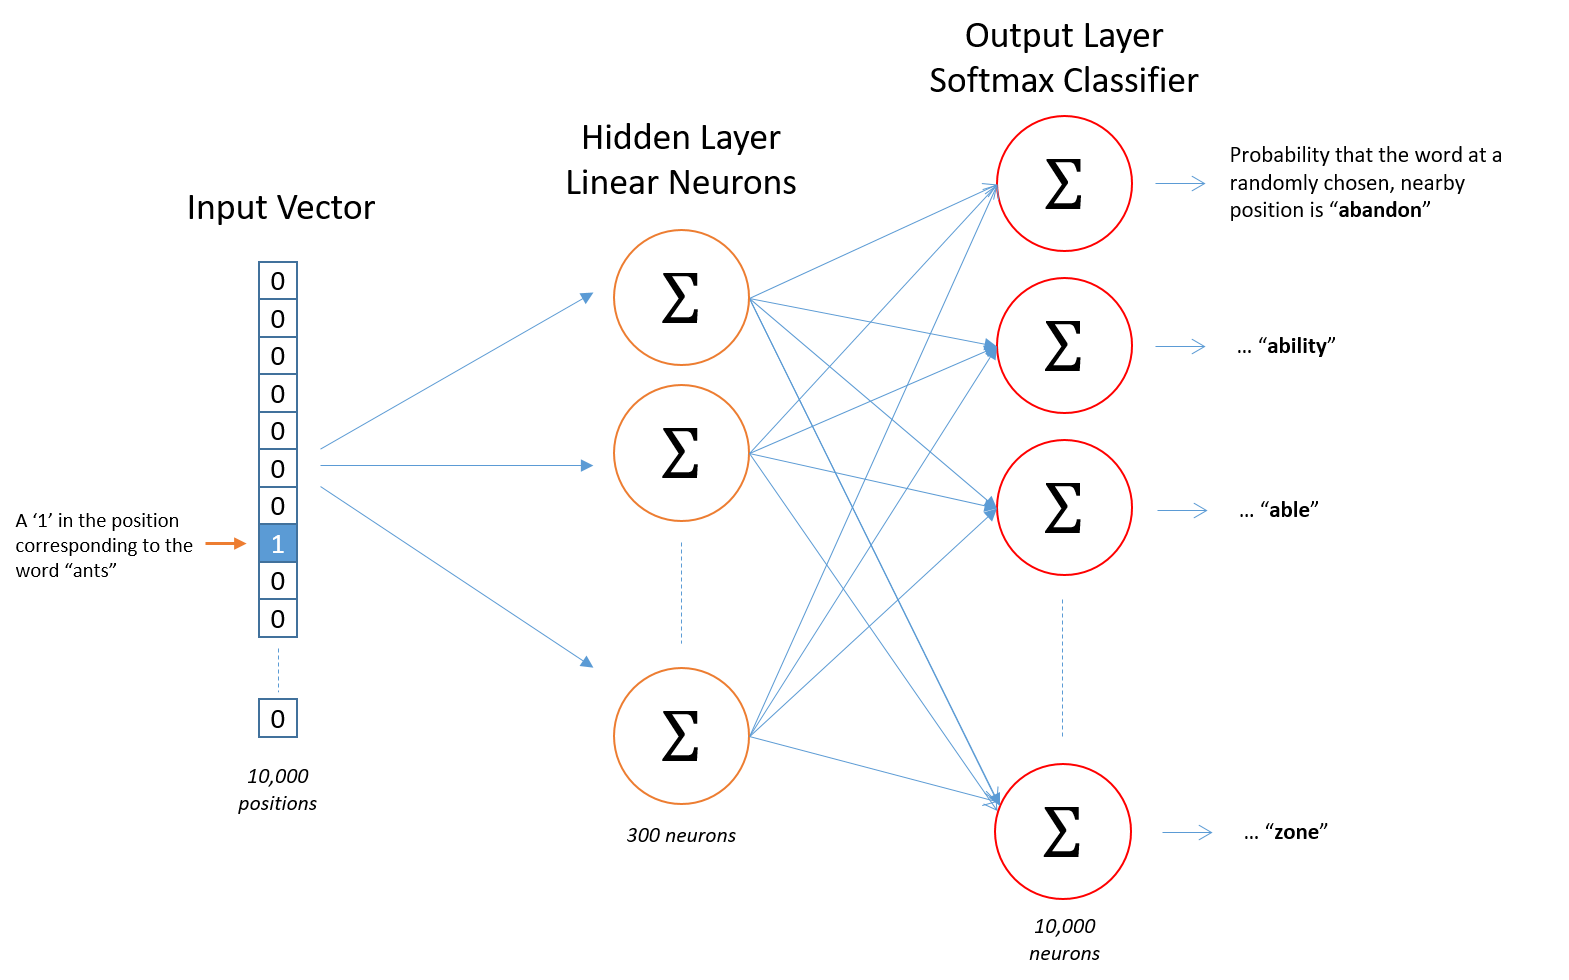

In [14]:
Image(filename="assets/skip_gram_net_arch.png", width='60%')

In [15]:
import torch
from torch import nn
import torch.optim as optim

In [16]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embedding = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        
        x = self.embedding(x)
        x = self.output(x)
        x = self.log_softmax(x)
              
        return x

## Cosine similarity

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$

In [17]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    
    embedding_vector = embedding.weight
    
    magnitudes = embedding_vector.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick 'valid_size' words from our ranges (0, window) and (1000, 1000+window). lower id implies more frequent 
    valid_sample = np.array(random.sample(range(valid_window), valid_size//2))
    valid_sample = np.append(valid_sample, np.array(random.sample(range(1000, 1000 + valid_window), valid_size//2)))
    # numpy to tensor
    valid_sample = torch.LongTensor(valid_sample).to(device)
    
    # list of weights of the valid_sample
    valid_vector = embedding(valid_sample)
    similarities = torch.mm(valid_vector, embedding_vector.t())/magnitudes
    
    return valid_sample, similarities

## Training

In [18]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [19]:
embedding_dim = 300
model = SkipGram(len(set(int_words)), embedding_dim).to(device)
model

SkipGram(
  (embedding): Embedding(63641, 300)
  (output): Linear(in_features=300, out_features=63641, bias=True)
  (log_softmax): LogSoftmax()
)

In [20]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [21]:
print_every = 1000
steps = 0
epochs = 5

for epoch in range(epochs):
    for inputs, targets in get_batches(train_words, batch_size = 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        loss.backward()
        optimizer.step()
        
        if steps % print_every == 0:
            valid_samples, similarities = cosine_similarity(model.embedding, device=device)
            _, top_words_idx = similarities.topk(6)
            
            valid_samples, top_words_idx = valid_samples.to('cpu'), top_words_idx.to('cpu')
            top_words_idx = top_words_idx.tolist()
            for i in range(len(top_words_idx)):
                top_words = list(map(lambda x: int2vocab[x], top_words_idx[i]))
                print(top_words[0] + ' | ' + ', '.join(top_words[1:]))
            print('----------')
                

world | legato, barbra, lexikon, octavia, subtly
state | myers, hypocrisy, sawyer, beads, rural
see | plantae, ath, michal, companions, nazaire
over | hoosier, lachlan, acl, angst, manorial
in | chilton, masses, tags, rickenbacker, technicalities
four | blender, stirner, divestment, repressor, immunoglobulin
other | coercion, ascendant, kona, tsonga, steinsaltz
used | pints, boosts, junk, exploitable, infinitives
frac | kerala, jade, excelled, hashemite, gounod
ice | reflecting, mirroring, unregistered, sapphire, yawkey
square | parlor, cluny, crossover, beheaded, chaffee
marriage | caviar, opticks, humanists, cruising, hugh
road | haken, orphans, rating, inviscid, captivity
primarily | anchor, hobbled, sigmoid, queue, drang
magazine | ect, decimus, sines, selena, omens
additional | feasts, mahathir, chronological, watchmakers, initiating
----------
so | cornwallis, legislation, collaborative, cocoanuts, bora
called | ejector, electoral, resonates, repaid, haifa
on | vinyl, pentium, el

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together.

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [23]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embedding.weight.to('cpu').data.numpy()

In [24]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

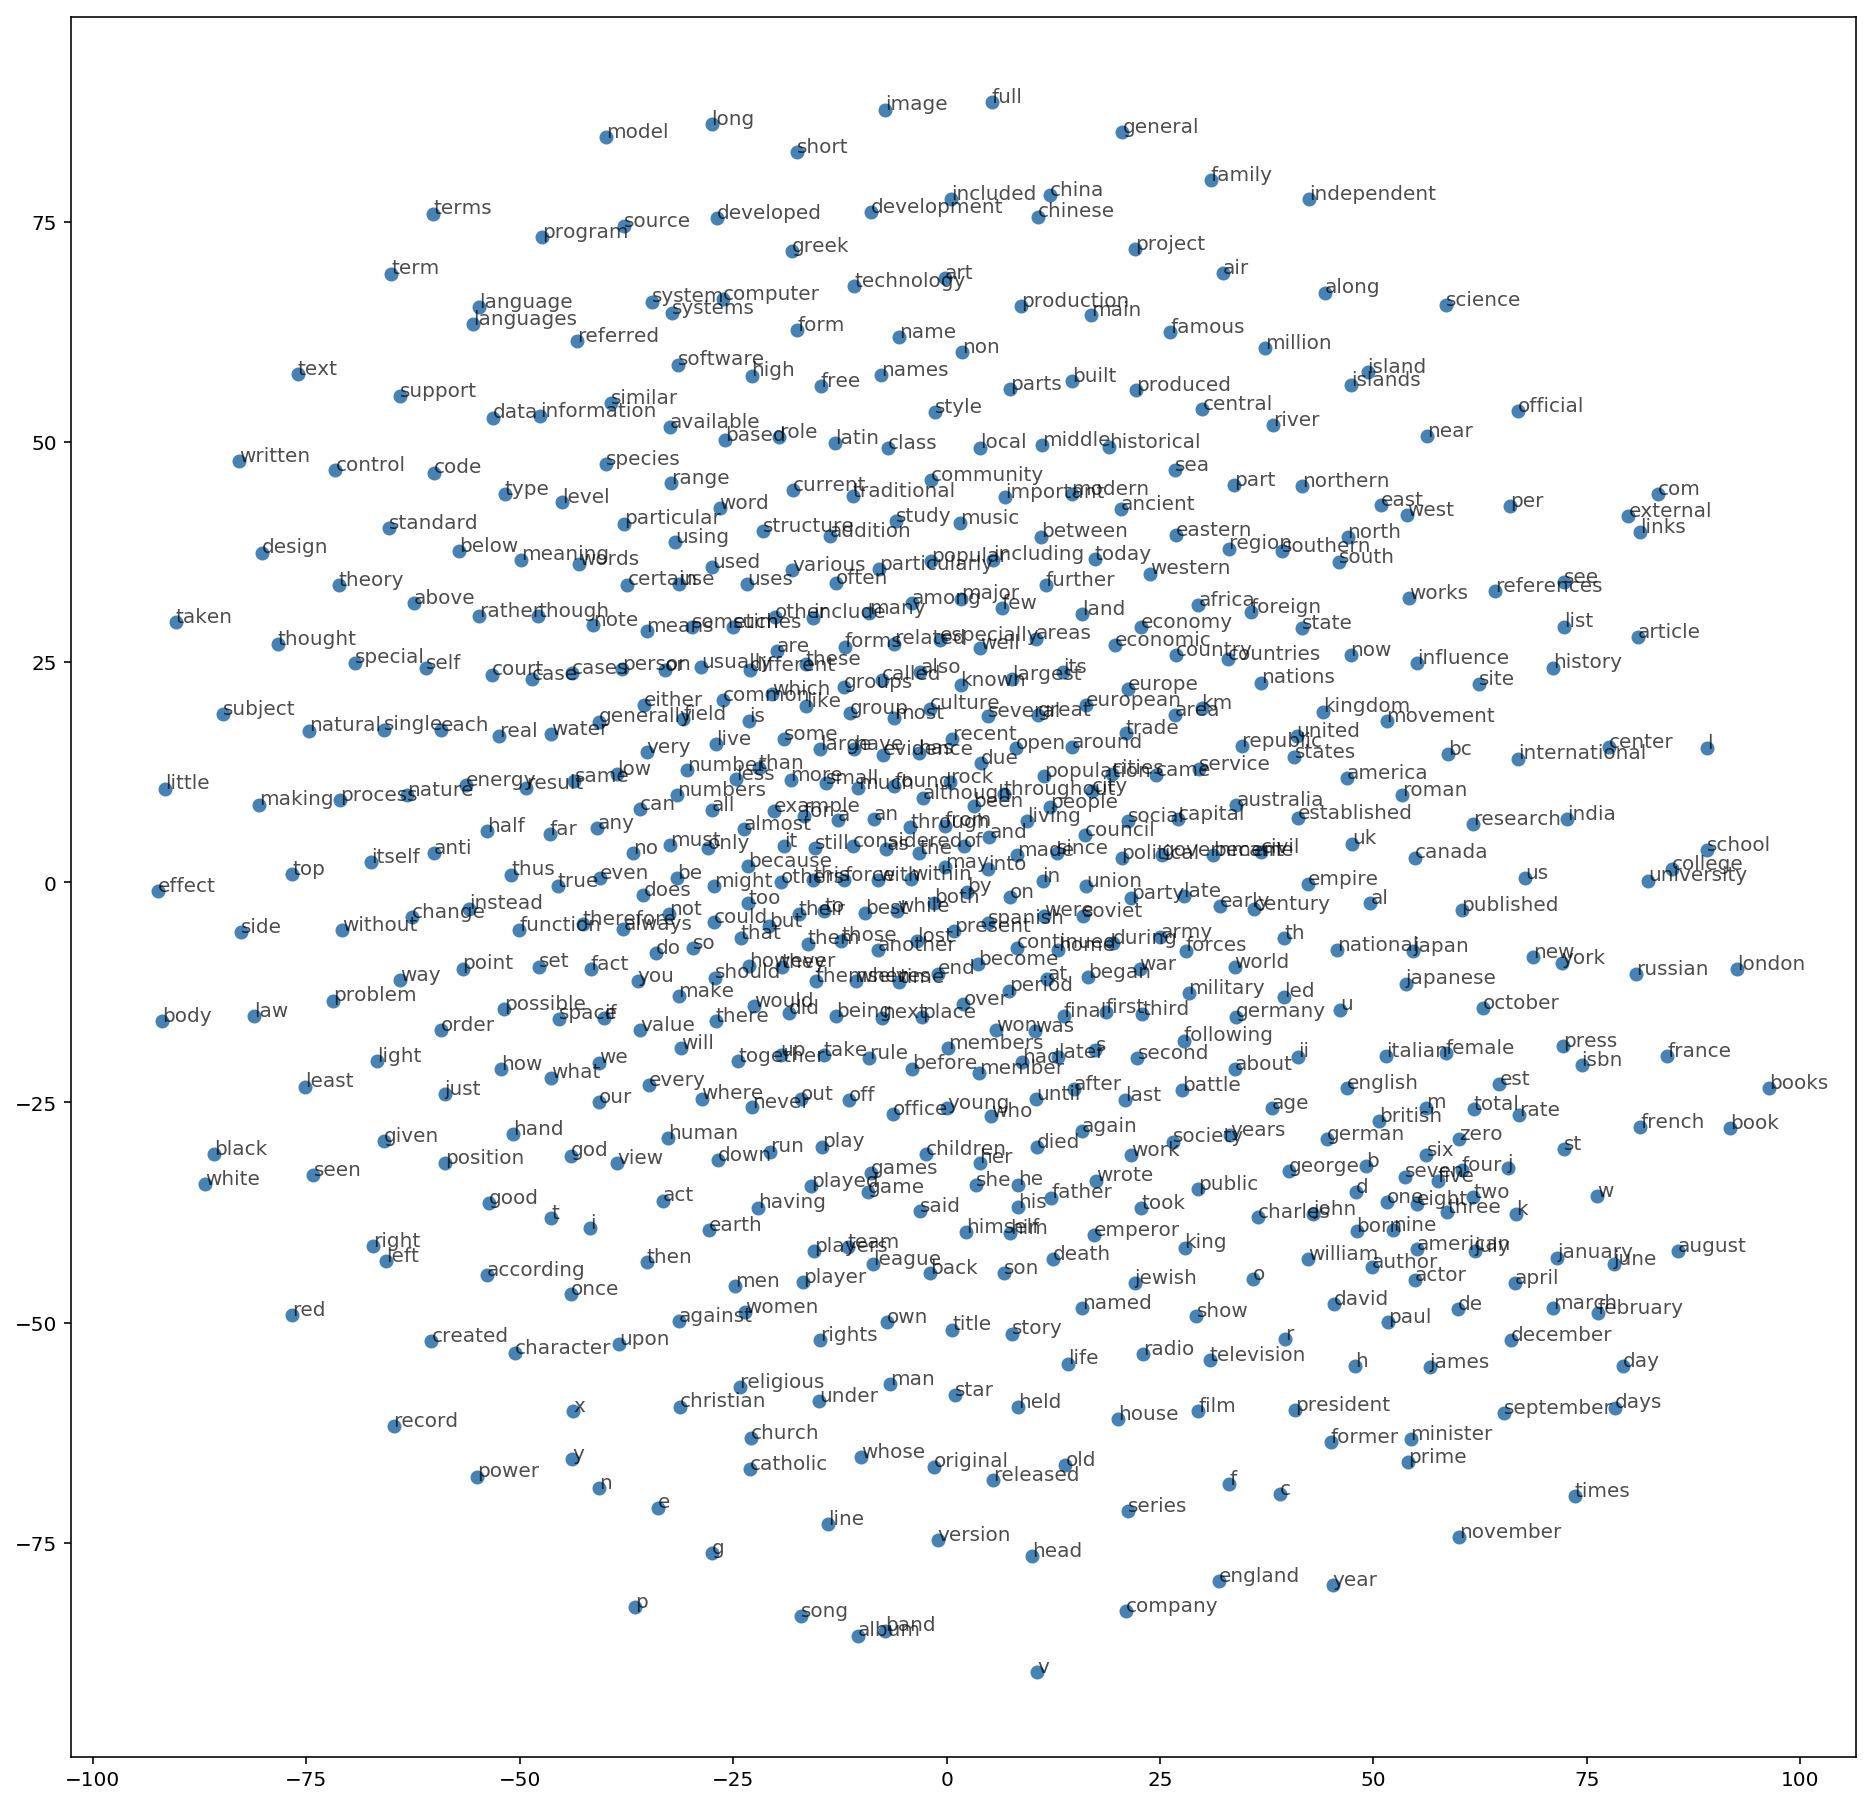

In [26]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int2vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)